In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [3]:
# hyperparameters
batch_size = 32
in_channels = 3
n_classes = 200
n_epochs = 80
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:',device)

device: cuda


In [4]:
def get_train_valid_dataloaders(train_set, valid_set, split_ratio, batch_size, shuffle=True, num_workers=2):
    idx = list(range(len(train_set)))
    
    if shuffle:
        np.random.shuffle(idx)
        
    split = int(np.floor(split_ratio * len(train_set)))
    
    train_idx, valid_idx = idx[split:], idx[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler) #, num_workers=num_workers
    valid_loader = DataLoader(valid_set, batch_size=batch_size, sampler=valid_sampler) #, num_workers=num_workers
    
    return train_loader, valid_loader

In [5]:
transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

In [6]:
train_dataset = ImageFolder(root="dataset_new/dataset_new", transform=transform)
train_loader, valid_loader = get_train_valid_dataloaders(train_dataset, train_dataset, 0.2, batch_size=batch_size)

In [7]:
num_images1 = len(train_loader) * train_loader.batch_size
num_images2 = len(valid_loader) * train_loader.batch_size
print(num_images1+num_images2)

1248


In [8]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)

torch.Size([32, 3, 224, 224])


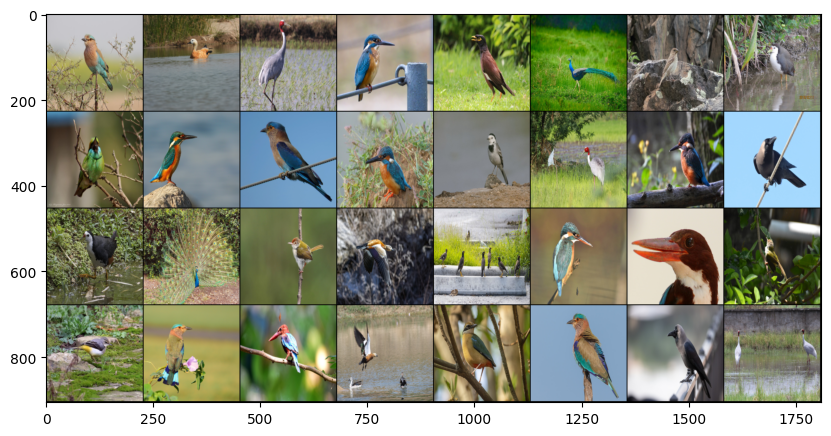

In [9]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
    

def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 

image_unorm = inv_normalize(images)
image_grid = make_grid(image_unorm)
imshow(image_grid)

In [10]:
class test1(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        
#         self.dropout = nn.Dropout(p=0.25)
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=96, padding='same', kernel_size=3)
        self.bn1 = nn.BatchNorm2d(96)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.4)
        
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=128, padding='same', kernel_size=5)
        self.bn2 = nn.BatchNorm2d(128)
        self.drop2 = nn.Dropout(p=0.1)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=384, padding='same', kernel_size=3)
        self.bn3 = nn.BatchNorm2d(384)
        self.drop3 = nn.Dropout(p=0.2)
        
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=448, padding='same', kernel_size=3)
        self.bn4 = nn.BatchNorm2d(448)
        self.drop4 = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(in_features=87808, out_features=128)
        self.bn5 = nn.BatchNorm1d(128)
        self.drop5 = nn.Dropout(p=0.1)
        
        self.fc2 = nn.Linear(in_features=128, out_features=96)
        self.bn6 = nn.BatchNorm1d(96)
        self.drop6 = nn.Dropout(p=0)
        
        self.fc3 = nn.Linear(in_features=96, out_features=self.n_classes)
                
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = self.drop1(x)
        
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.max_pool(x)
        x = self.drop2(x)
        
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.max_pool(x)
        x = self.drop3(x)
        
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.max_pool(x)
        x = self.drop4(x)

        x = x.view(x.shape[0], -1)
        x = torch.relu(self.bn5(self.fc1(x)))
        x = self.drop5(x)
        x = torch.relu(self.bn6(self.fc2(x)))
        x = self.drop6(x)
        logit = self.fc3(x)
        return logit

In [11]:
# from torchvision.models import alexnet
# import torchvision

# model = torchvision.models.alexnet(pretrained=True).to(device)

# for param in model.parameters():
#     param.requires_grad = False

# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, 25)

In [ ]:
from torchvision.models import resnet152
import torchvision

if input("Method 1 or 2:") == '1':
    model = test1(in_channels, n_classes).to(device)
    model.load_state_dict(torch.load('bird_best_model.pth'))

    for param in model.parameters():
        param.requires_grad = False

    n_classes = 25
    num_ftrs = model.fc3.in_features
    model.fc3 = nn.Linear(num_ftrs, n_classes)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
else:
    model = torchvision.models.resnet152(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False

    n_classes = 25
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 25)
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'param name: {name}, shape: {param.shape}')

param name: fc.weight, shape: torch.Size([25, 2048])
param name: fc.bias, shape: torch.Size([25])


In [15]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

In [16]:
def train(model, train_loader, device, optimizer, loss_fn):
    model.train()
    
    n_corrects = 0
    total = 0
    train_loss = 0.
    step = 0
    for idx, (images, labels) in enumerate(train_loader):
#         print(images.shape)
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        _, predictions = torch.max(outputs, dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        current_lr = optimizer.param_groups[0]["lr"]
        step += 1
        
        train_accuracy = 100. * n_corrects/total
    
        avg_train_loss = train_loss/(idx+1)
        if (idx+1) % 100 == 0:
            print(f'Batch: [{idx+1}/{len(train_loader)}], Training Loss: {avg_train_loss:.3f} | Training Acc: {train_accuracy:.2f}% | lr: {current_lr:.5f}')  

    avg_train_loss = train_loss/(step+1)
    train_accuracy = 100. * n_corrects/total
    return avg_train_loss, train_accuracy

@torch.no_grad()
def valid(model, valid_loader, device, loss_fn):
    n_corrects = 0
    total = 0
    valid_loss = 0.
    idx = 0
    model.eval()
    for idex, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        loss = loss_fn(outputs, labels)
        valid_loss += loss.item()
        idx += 1
    avg_valid_loss = valid_loss/(idx+1)
    valid_accuracy = 100 * n_corrects/total
    return avg_valid_loss, valid_accuracy

In [17]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'---Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [18]:
n_epochs = 150
is_valid_available = True
early_stopping = EarlyStopping(patience=5, verbose=True)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, train_loader, device, optimizer, loss_fn)
    valid_loss, valid_accuracy = valid(model, valid_loader, device, loss_fn)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_accuracy_list.append(train_accuracy)
    valid_accuracy_list.append(valid_accuracy)
    
    if scheduler is not None and is_valid_available:
        scheduler.step(valid_loss)
    elif scheduler is not None:
        scheduler.step()
    
    print(f'[{epoch+1}/{n_epochs}] | validation loss: {valid_loss:.4f} | validation accuracy: {valid_accuracy:.2f}%')

    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

C:\Users\User\anaconda3\envs\python39-env\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[1/150] | validation loss: 2.5541 | validation accuracy: 28.40%
---Validation loss decreased (inf --> 2.554056).  Saving model ...
[2/150] | validation loss: 2.1291 | validation accuracy: 56.79%
---Validation loss decreased (2.554056 --> 2.129062).  Saving model ...
[3/150] | validation loss: 1.7965 | validation accuracy: 70.78%
---Validation loss decreased (2.129062 --> 1.796534).  Saving model ...
[4/150] | validation loss: 1.5354 | validation accuracy: 77.78%
---Validation loss decreased (1.796534 --> 1.535386).  Saving model ...
[5/150] | validation loss: 1.3560 | validation accuracy: 80.25%
---Validation loss decreased (1.535386 --> 1.355968).  Saving model ...
[6/150] | validation loss: 1.1904 | validation accuracy: 85.60%
---Validation loss decreased (1.355968 --> 1.190400).  Saving model ...
[7/150] | validation loss: 1.0947 | validation accuracy: 82.72%
---Validation loss decreased (1.190400 --> 1.094693).  Saving model ...
[8/150] | validation loss: 0.9956 | validation accura

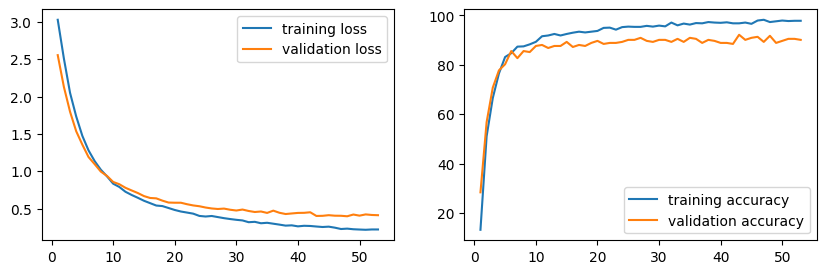

In [19]:
# fig, ax = plt.subplots(figsize=(10,8))
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()
ax2.plot(range(1, len(train_accuracy_list)+1), train_accuracy_list, label="training accuracy")
ax2.plot(range(1, len(valid_accuracy_list)+1), valid_accuracy_list, label="validation accuracy")
ax2.legend()
plt.show()

In [20]:
print(max(train_accuracy_list))
print(max(valid_accuracy_list))

98.25641025641026
92.18106995884774


In [21]:
print(min(train_loss_list))
print(min(valid_loss_list))

0.2171121067367494
0.3977911174297333
